## Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import pandas as pd
from tqdm import tqdm
from astropy.visualization.hist import hist as fancyhist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [2]:
#Loading the data
data = h5py.File('../../../sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

dataframe_list = []
for key in data.keys():
    dataset = data[key][:10000]
    df = pd.DataFrame(dataset)
    dataframe_list.append(df)

#Reordering the features
df_data = pd.concat(dataframe_list, axis=1)
labels = list(data.keys())
df_data.columns = labels
ind_det = labels.index('det')
ind_z = labels.index('z')
labels[ind_det], labels[ind_z] = labels[ind_z], labels[ind_det]
df_data = df_data[labels]

In [3]:
df_data

,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,z,iota,mtot,psi,q,ra,snr,det
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,2.139659,1.809310,906.803562,1.286031,0.624780,-3.116784,0.822509,0
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,2.438707,0.820820,59.102112,0.934308,0.986650,1.360291,1.093237,0
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,1.869461,2.008206,44.602750,1.535520,0.286199,0.079973,1.305398,0
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0.428061,2.018398,534.378032,3.064086,0.538882,-1.780558,9.112974,0
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,0.772609,2.037363,573.821705,0.752211,0.846310,2.789289,17.525534,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.708728,0.121567,-0.176741,-0.230727,-0.075879,-0.246178,-0.340009,2.657802,1.087315,86.351265,3.042551,0.377024,1.121244,0.493245,0
9996,-0.005258,-0.749190,-0.064408,-0.094181,-0.344792,0.158509,-0.253670,0.205389,1.148764,851.363073,0.741488,0.777002,-2.559599,38.949247,1
9997,-0.069132,0.197611,0.220038,-0.142640,0.043409,-0.145898,0.346487,1.578344,0.674179,755.717002,2.328629,0.824103,-2.626533,5.503841,0
9998,0.395435,-0.810716,-0.177584,-0.835584,-0.189410,0.338516,0.724885,0.198390,2.168764,868.403736,2.619739,0.210378,2.223352,19.288054,1


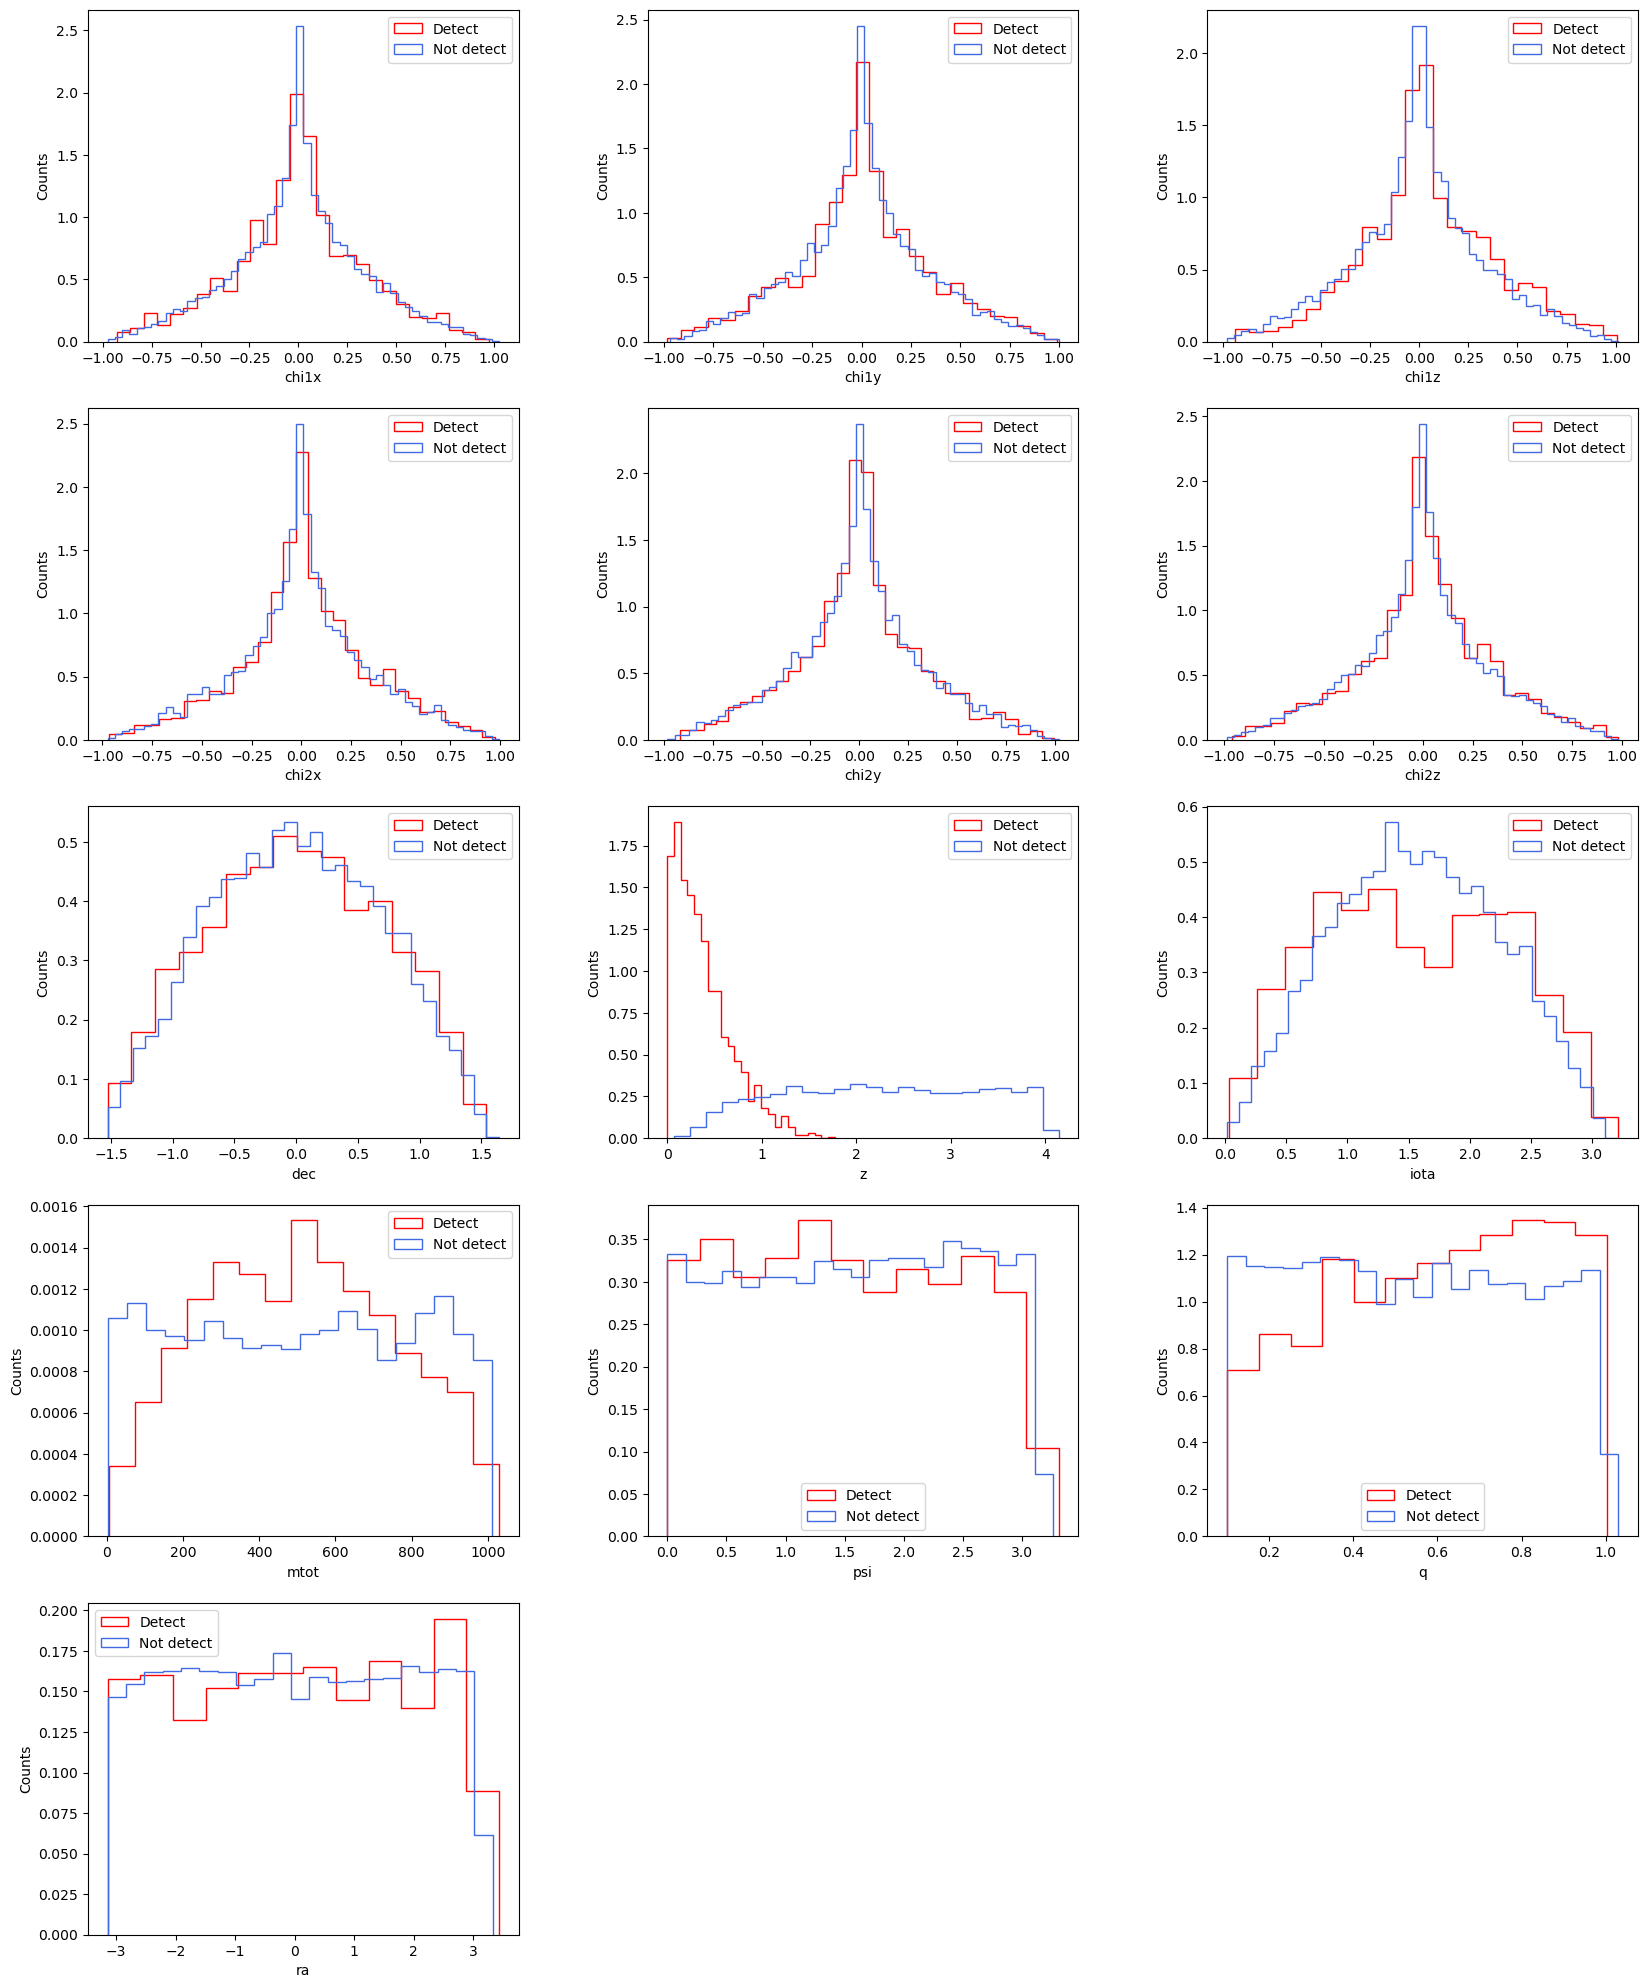

In [4]:
#Histogram of all the features
fig, axs = plt.subplots(5, 3, figsize=(20, 25))

k=0
for i in range(5):
    for j in range(3):
        if (df_data.columns[k]!='det') and (df_data.columns[k]!='snr'):
            fancyhist(df_data.loc[df_data['det'] == 1, df_data.columns[k]], bins="freedman", ax=axs[i,j], \
                      density=True, ec='red', histtype='step', label = 'Detect')
            fancyhist(df_data.loc[df_data['det'] == 0, df_data.columns[k]], bins="freedman", ax=axs[i,j], \
                      density=True, ec='royalblue', histtype='step', label = 'Not detect')
            axs[i,j].set_xlabel(df_data.columns[k])
            axs[i,j].set_ylabel('Counts')
            axs[i,j].legend()
        k+=1

for l in range(13, 15):
    fig.delaxes(axs.flatten()[l])

plt.subplots_adjust(wspace=0.3)
plt.show()

We can see that it's very difficult to distinguish from a source that has been detected and one that has not looking at the features individually, apart from the redshift.

In [5]:
#Scaling our data and dividing them into a train set and a test set
scaler = StandardScaler().set_output(transform="pandas")
data_scaled = scaler.fit_transform(df_data[labels[:13]])
X_train, X_test, y_train, y_test = train_test_split(data_scaled.to_numpy(), df_data['det'], test_size=0.3, random_state=42)

In [6]:
n_feature = np.arange(1, 14)

#Function to compute the completeness and the contamination as functions of the number of features 
def compl_cont(clf, X_train, X_test, y_train, y_test):
    predictions = []
    confusion = []
    for i in tqdm(n_feature):
        clf.fit(X_train[:, :i], y_train)  #Fitting the data
        y_pred = clf.predict(X_test[:, :i])  #Predicting the labels
    
        predictions.append(y_pred)
        confusion.append(confusion_matrix(y_test, y_pred))  #Computing the confusion matrix
    
    completeness, contamination = completeness_contamination(predictions, y_test)  #Computing the completeness and the contamination
    return completeness, contamination, confusion

#Function to plot the completeness and the contamination as functions of the number of features
def plots(clf, X_train, y_train, completeness, contamination, red = False):
    clf.fit(X_train, y_train)
    
    fig = plt.figure(figsize=(10, 4))
    fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                        left=0.1, right=0.95, wspace=0.2)
    
    ax = fig.add_subplot(222)
    ax.plot(n_feature, completeness, color = 'black', marker = 'o')
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('Completeness')
    ax.grid(alpha=0.3)
    
    ax = fig.add_subplot(224)
    ax.plot(n_feature, contamination, color = 'black', marker = 'o')
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
    if red == False:
        ax.set_xlabel('N features')
    else:
        ax.set_xlabel('N components')
    ax.set_ylabel('Contamination')
    ax.grid(alpha=0.3)
    
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## PCA

I will also try to perform the classification on the PCA components

In [7]:
pca = PCA()  #Defining the PCA estimator object
pca.fit(data_scaled)  #Fitting the data
evals = pca.explained_variance_ratio_  #Computing the eigenvalues
eigenvectors = np.asarray(pca.components_, dtype=float)  #Computing the eigenvectors
data_pca = pca.transform(data_scaled)  #Trasforming the data

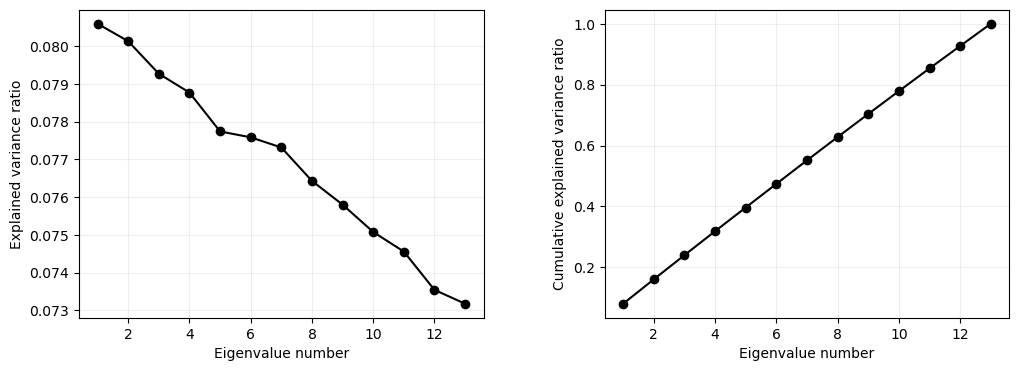

In [8]:
#Plotting the scree plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(np.arange(1, len(evals)+1), evals, color = 'black', marker='o')
axs[0].set_xlabel('Eigenvalue number')
axs[0].set_ylabel('Explained variance ratio')
axs[0].grid(alpha=0.2)

axs[1].plot(np.arange(1, len(evals)+1), evals.cumsum(), color = 'black', marker='o')
axs[1].set_xlabel('Eigenvalue number')
axs[1].set_ylabel('Cumulative explained variance ratio')
axs[1].grid(alpha=0.2)

plt.subplots_adjust(wspace=0.3)
plt.show()

In [9]:
#Splitting the PCA data into a train set and a test set
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, df_data['det'], test_size=0.3, random_state=42)

## Logistic regression

#### Without PCA

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.

In [10]:
LR = LogisticRegression(class_weight='balanced')
completeness_LR, contamination_LR, confusion_LR = compl_cont(LR, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:00<00:00, 96.79it/s]


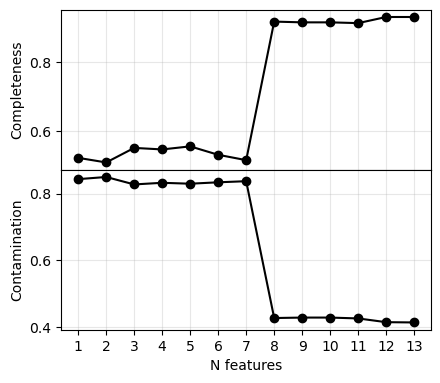

In [11]:
plots(LR, X_train[:,[7,9]], y_train, completeness_LR, contamination_LR)

#### With PCA

In [12]:
LR_pca = LogisticRegression(class_weight='balanced')
completeness_LR_pca, contamination_LR_pca, confusion_LR_pca = compl_cont(LR_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:00<00:00, 113.70it/s]


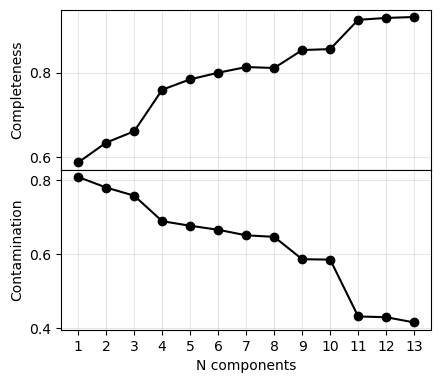

In [13]:
plots(LR_pca, X_train_pca[:,:2], y_train_pca, completeness_LR_pca, contamination_LR_pca, red = True)

In [14]:
#Printing the completeness and contamination for both the cases 
print('Without PCA:')
print('Completeness:\n', completeness_LR)
print('Contamination:\n', contamination_LR)
print('\nWith PCA:')
print('Completeness:\n', completeness_LR_pca)
print('Contamination:\n', contamination_LR_pca)

Without PCA:
Completeness:
 [0.52115813 0.5077951  0.55011136 0.54565702 0.5545657  0.53006682
 0.51447661 0.91759465 0.91536748 0.91536748 0.91314031 0.93095768
 0.93095768]
Contamination:
 [0.84347826 0.84990125 0.82763433 0.83253589 0.82980178 0.83403068
 0.83732394 0.42777778 0.42916667 0.42916667 0.42657343 0.41538462
 0.41456583]

With PCA:
Completeness:
 [0.58797327 0.63474388 0.66146993 0.75946548 0.78396437 0.79955457
 0.81291759 0.81069042 0.85300668 0.85523385 0.92427617 0.92873051
 0.93095768]
Contamination:
 [0.80772032 0.7792409  0.75715454 0.68829982 0.67587477 0.66511194
 0.65004794 0.6459144  0.58549784 0.58441558 0.43072702 0.42876712
 0.41456583]


In [15]:
#Printing the confusion matrixes in the case of maximum completeness for both the cases
print('Confusion matrix\nWithout PCA:\n', confusion_LR[np.argmax(completeness_LR)])
print('\nWith PCA:\n', confusion_LR_pca[np.argmax(completeness_LR_pca)])

Confusion matrix
Without PCA:
 [[2254  297]
 [  31  418]]

With PCA:
 [[2255  296]
 [  31  418]]


## Support vector machines

#### Without PCA

In [16]:
#Cross validation to compute the best 'regularization parameter' C
crange = np.linspace(0.01, 10, 25)
k = 5
grid = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), {'C': crange}, cv= k)
grid.fit(X_train, y_train)
best_c = grid.best_params_['C']
print(best_c)

1.675


In [17]:
SVM = SVC(kernel='linear', class_weight='balanced', C = best_c)
completeness_SVC, contamination_SVC, confusion_SVC = compl_cont(SVM, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


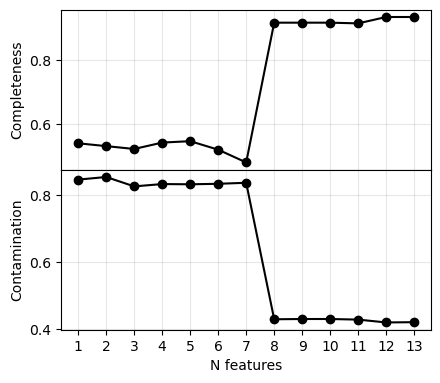

In [18]:
plots(SVM, X_train[:,[7,9]], y_train, completeness_SVC, contamination_SVC)

#### With PCA

In [19]:
#Cross validation to compute the best 'regularization parameter' C
grid = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), {'C': crange}, cv= k)  
grid.fit(X_train_pca, y_train_pca)
best_c_pca = grid.best_params_['C']
print(best_c_pca)

1.675


In [20]:
SVM_pca = SVC(kernel='linear', class_weight='balanced', C = best_c_pca)
completeness_SVC_pca, contamination_SVC_pca, confusion_SVC_pca = compl_cont(SVM_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:36<00:00,  2.81s/it]


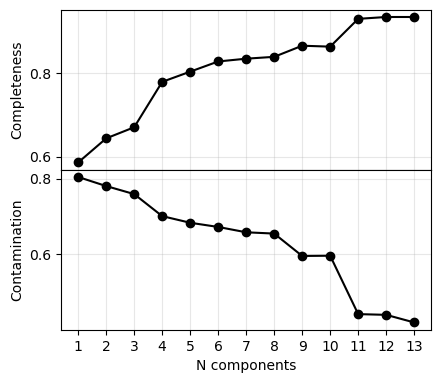

In [21]:
plots(SVM_pca, X_train_pca[:,:2], y_train_pca, completeness_SVC_pca, contamination_SVC_pca, red = True)

In [22]:
#Printing the completeness and contamination for both the cases 
print('Without PCA:')
print('Completeness:\n', completeness_SVC)
print('Contamination:\n', contamination_SVC)
print('\nWith PCA:')
print('Completeness:\n', completeness_SVC_pca)
print('Contamination:\n', contamination_SVC_pca)

Without PCA:
Completeness:
 [0.5389755  0.53006682 0.52115813 0.54120267 0.54565702 0.51893096
 0.47884187 0.91759465 0.91759465 0.91759465 0.91536748 0.93541203
 0.93541203]
Contamination:
 [0.84556477 0.85335798 0.82537313 0.83229814 0.83161512 0.83309456
 0.83612805 0.42936288 0.43015214 0.43015214 0.42837274 0.4198895
 0.42068966]

With PCA:
Completeness:
 [0.5857461  0.64365256 0.67037862 0.77951002 0.80400891 0.8285078
 0.83518931 0.83964365 0.86636971 0.86414254 0.93095768 0.93541203
 0.93541203]
Contamination:
 [0.80431548 0.78039514 0.7592     0.70111016 0.68361087 0.67253521
 0.65846995 0.65507777 0.596054   0.5966736  0.44266667 0.44074567
 0.42068966]


In [23]:
#Printing the confusion matrixes in the case of maximum completeness for both the cases
print('Confusion matrix\nWithout PCA:\n', confusion_SVC[np.argmax(completeness_SVC)])
print('\nWith PCA:\n', confusion_SVC_pca[np.argmax(completeness_SVC_pca)])

Confusion matrix
Without PCA:
 [[2247  304]
 [  29  420]]

With PCA:
 [[2220  331]
 [  29  420]]


## RBF Kernel

I'm gonna use a radial basis function (also known as Gaussian kernel).

In [24]:
#Cross validation to compute the best 'regularization parameter' C
crange = np.linspace(1, 2.5, 5)
gammarange = np.linspace(0.1, 2, 5)
k = 5
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), {'C': crange, 'gamma': gammarange}, cv= k)
grid.fit(X_train, y_train)
best_c = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']
print(best_c, best_gamma)

"#Cross validation to compute the best 'regularization parameter' C\ncrange = np.linspace(1, 2.5, 5)\ngammarange = np.linspace(0.1, 2, 5)\nk = 5\ngrid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), {'C': crange, 'gamma': gammarange}, cv= k)\ngrid.fit(X_train, y_train)\nbest_c = grid.best_params_['C']\nbest_gamma = grid.best_params_['gamma']\nprint(best_c, best_gamma)"

In [25]:
#best_c = 2.5
#best_gamma = 0.1

In [26]:
rbf = SVC(kernel='rbf', class_weight='balanced', C = best_c, gamma = best_gamma)
completeness_rbf, contamination_rbf, confusion_rbf = compl_cont(rbf, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:54<00:00,  4.20s/it]


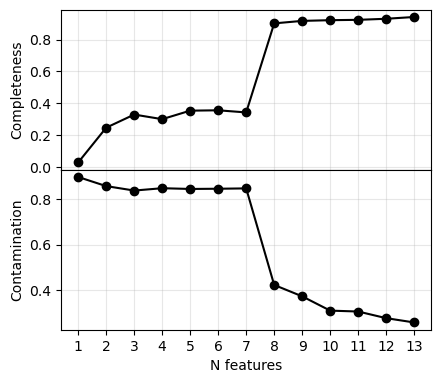

In [27]:
plots(rbf, X_train[:,[7,9]], y_train, completeness_rbf, contamination_rbf)

#### With PCA

In [28]:
rbf_pca = SVC(kernel='rbf', class_weight='balanced', C = best_c_pca, gamma = best_gamma)
completeness_rbf_pca, contamination_rbf_pca, confusion_rbf_pca = compl_cont(rbf_pca, X_train_pca, X_test_pca, y_train_pca, y_test)

100%|██████████| 13/13 [00:47<00:00,  3.67s/it]


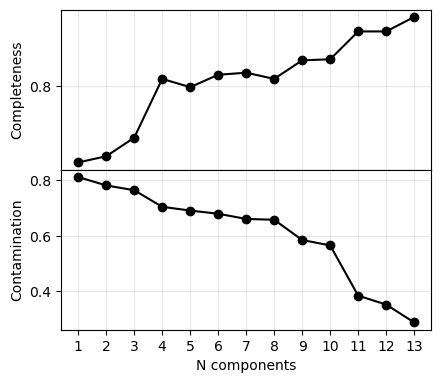

In [29]:
plots(rbf_pca, X_train_pca[:,:2], y_train_pca, completeness_rbf_pca, contamination_rbf_pca, red = True)

In [30]:
#Printing the completeness and contamination for both the cases
print('Without PCA:')
print('Completeness:\n', completeness_rbf)
print('Contamination:\n', contamination_rbf)
print('\nWith PCA:')
print('Completeness:\n', completeness_rbf_pca)
print('Contamination:\n', contamination_rbf_pca)

Without PCA:
Completeness:
 [0.02895323 0.24721604 0.32962138 0.30066815 0.35412027 0.35634744
 0.34298441 0.90200445 0.91759465 0.922049   0.92427617 0.93095768
 0.94209354]
Contamination:
 [0.89922481 0.85895807 0.8393051  0.84966592 0.84637681 0.84732824
 0.84887144 0.42225392 0.37195122 0.30884808 0.30485762 0.27556326
 0.25659051]

With PCA:
Completeness:
 [0.63474388 0.6481069  0.68819599 0.81514477 0.79732739 0.82405345
 0.8285078  0.81514477 0.85523385 0.85746102 0.91759465 0.91759465
 0.94877506]
Contamination:
 [0.8121292  0.78169542 0.76448171 0.70460048 0.69111303 0.67965368
 0.66089335 0.65794393 0.58486486 0.56546275 0.38415546 0.35220126
 0.28762542]


In [31]:
#Printing the confusion matrixes in the case of maximum completeness for both the cases
print('Confusion matrix\nWithout PCA:\n', confusion_rbf[np.argmax(completeness_rbf)])
print('\nWith PCA:\n', confusion_rbf_pca[np.argmax(completeness_rbf_pca)])

Confusion matrix
Without PCA:
 [[2405  146]
 [  26  423]]

With PCA:
 [[2379  172]
 [  23  426]]


## Decision tree classifier

I'm gonna use the entropy as splitting criteria.

#### Without PCA

In [32]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4,  class_weight='balanced')
completeness_dtc, contamination_dtc, confusion_dtc = compl_cont(dtc, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:00<00:00, 17.25it/s]


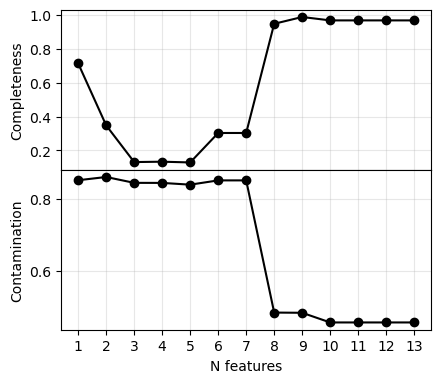

In [33]:
plots(dtc, X_train[:,[7,9]], y_train, completeness_dtc, contamination_dtc)

#### With PCA

In [34]:
completeness_dtc_pca, contamination_dtc_pca, confusion_dtc_pca = compl_cont(dtc, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:00<00:00, 18.26it/s]


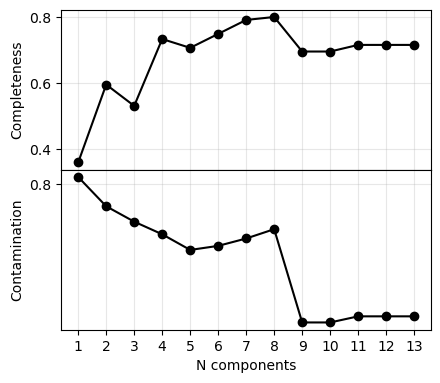

In [35]:
plots(dtc, X_train_pca[:,:2], y_train_pca, completeness_dtc_pca, contamination_dtc_pca, red = True)

In [36]:
#Printing the completeness and contamination for both the cases
print('Without PCA:')
print('Completeness:\n', completeness_dtc)
print('Contamination:\n', contamination_dtc)
print('\nWith PCA:')
print('Completeness:\n', completeness_dtc_pca)
print('Contamination:\n', contamination_dtc_pca)

Without PCA:
Completeness:
 [0.71269488 0.34743875 0.13140312 0.13363029 0.12917595 0.30289532
 0.30289532 0.94654788 0.98663697 0.96659243 0.96659243 0.96659243
 0.96659243]
Contamination:
 [0.85116279 0.86008969 0.84391534 0.84375    0.83888889 0.8507135
 0.8507135  0.48547215 0.48488372 0.45817728 0.45817728 0.45817728
 0.45817728]

With PCA:
Completeness:
 [0.35857461 0.59465479 0.53006682 0.73273942 0.70601336 0.74832962
 0.79064588 0.79955457 0.69487751 0.69487751 0.71492205 0.71492205
 0.71492205]
Contamination:
 [0.80508475 0.78398058 0.77290076 0.7638191  0.75253708 0.75545852
 0.76078167 0.76748705 0.70028818 0.70028818 0.70469181 0.70469181
 0.70469181]


In [37]:
#Printing the confusion matrixes in the case of maximum completeness for both the cases
print('Confusion matrix\nWithout PCA:\n', confusion_dtc[np.argmax(completeness_dtc)])
print('\nWith PCA:\n', confusion_dtc_pca[np.argmax(completeness_dtc_pca)])

Confusion matrix
Without PCA:
 [[2134  417]
 [   6  443]]

With PCA:
 [[1366 1185]
 [  90  359]]


In the next cell I compute the completeness and the contamination for different number of feature and I iterate the computation for different depths of the tree. Then I plot only those with the highest contamination as a function of the depth. 

In [38]:
depths = np.arange(1,11)
compl = []
cont = []
compl_pca = []
cont_pca = []
for d in depths:
    dec = DecisionTreeClassifier(criterion='entropy', max_depth=d,  class_weight='balanced')
    compl_dtc, cont_dtc, conf_dtc = compl_cont(dec, X_train, X_test, y_train, y_test)
    compl_dtc_pca, cont_dtc_pca, conf_dtc_pca = compl_cont(dec, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

    compl.append(max(compl_dtc))
    cont.append(cont_dtc[np.argmax(compl_dtc)])

    compl_pca.append(max(compl_dtc_pca))
    cont_pca.append(cont_dtc_pca[np.argmax(compl_dtc_pca)])

100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


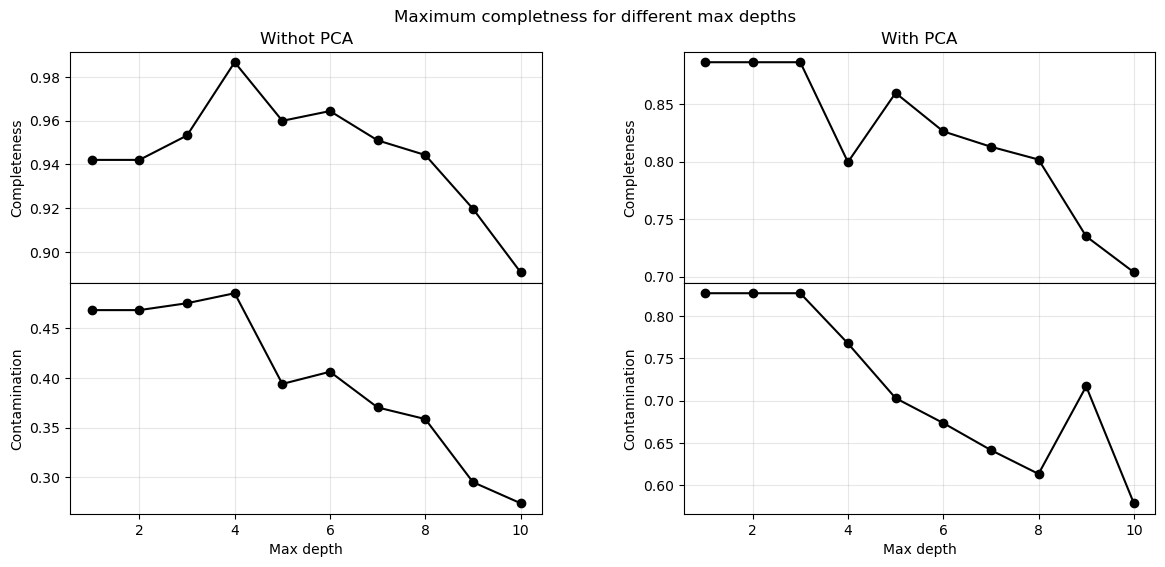

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.3, 'hspace': 0})

axs[0,0].plot(depths, compl, color = 'black', marker = 'o')
axs[0,0].set_title('Withot PCA')
axs[0,0].set_ylabel('Completeness')
axs[0,0].grid(alpha=0.3)
axs[1,0].plot(depths, cont, color = 'black', marker = 'o')
axs[1,0].set_ylabel('Contamination')
axs[1,0].set_xlabel('Max depth')
axs[1,0].grid(alpha=0.3)

axs[0,1].plot(depths, compl_pca, color = 'black', marker = 'o')
axs[0,1].set_title('With PCA')
axs[0,1].set_ylabel('Completeness')
axs[0,1].grid(alpha=0.3)
axs[1,1].plot(depths, cont_pca, color = 'black', marker = 'o')
axs[1,1].set_ylabel('Contamination')
axs[1,1].set_xlabel('Max depth')
axs[1,1].grid(alpha=0.3)

plt.suptitle('Maximum completness for different max depths', y=0.95)
plt.show()

## Bagging

- n_estimator: Number of decision trees;
- max_samples: The model will sample a maximum of 100 samples with replacement (bootstrap sampling) from the data for each tree;
- n_jobs=-1: It uses all available processor cores to speed up the training process.

#### Without PCA

In [40]:
bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', class_weight='balanced', max_depth=4), 
                        n_estimators=500, max_samples=100, random_state=42, n_jobs=-1)
completeness_bag, contamination_bag, confusion_bag = compl_cont(bag, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


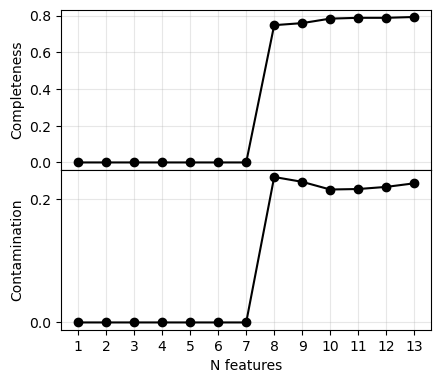

In [41]:
plots(bag, X_train[:,[7,9]], y_train, completeness_bag, contamination_bag)

#### With PCA

In [42]:
completeness_bag_pca, contamination_bag_pca, confusion_bag_pca = compl_cont(bag, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:14<00:00,  1.15s/it]


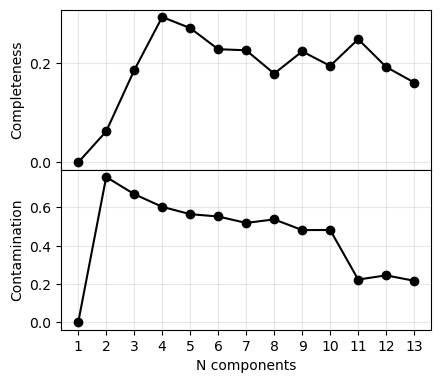

In [43]:
plots(bag, X_train_pca[:,:2], y_train_pca, completeness_bag_pca, contamination_bag_pca, red = True)

In [44]:
#Printing the completeness and contamination for both the cases
print('Without PCA:')
print('Completeness:\n', completeness_bag)
print('Contamination:\n', contamination_bag)
print('\nWith PCA:')
print('Completeness:\n', completeness_bag_pca)
print('Contamination:\n', contamination_bag_pca)

Without PCA:
Completeness:
 [0.         0.         0.         0.         0.         0.
 0.         0.74832962 0.75946548 0.78396437 0.78841871 0.78841871
 0.79287305]
Contamination:
 [0.         0.         0.         0.         0.         0.
 0.         0.23636364 0.22850679 0.21603563 0.21681416 0.22026432
 0.22608696]

With PCA:
Completeness:
 [0.         0.0623608  0.18485523 0.29175947 0.26948775 0.22717149
 0.22494432 0.17817372 0.22271715 0.19376392 0.24721604 0.19153675
 0.16035635]
Contamination:
 [0.         0.75862069 0.66932271 0.6030303  0.5647482  0.55263158
 0.51904762 0.53757225 0.48186528 0.48214286 0.22377622 0.24561404
 0.2173913 ]


In [45]:
#Printing the confusion matrixes in the case of maximum completeness for both the cases
print('Confusion matrix\nWithout PCA:\n', confusion_bag[np.argmax(completeness_bag)])
print('\nWith PCA:\n', confusion_bag_pca[np.argmax(completeness_bag_pca)])

Confusion matrix
Without PCA:
 [[2447  104]
 [  93  356]]

With PCA:
 [[2352  199]
 [ 318  131]]


## Random Forest

In [46]:
depthrange = np.arange(1, 11)
k = 5
grid = GridSearchCV(RandomForestClassifier(criterion='entropy', class_weight='balanced', n_jobs=-1), \
                    {'max_depth': depthrange}, cv= k)
grid.fit(X_train, y_train)
best_depth = grid.best_params_['max_depth']
print(best_depth)

10


#### Without PCA

In [47]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=best_depth, class_weight='balanced', n_jobs=-1)
completeness_rfc, contamination_rfc, confusion_rfc = compl_cont(rfc, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


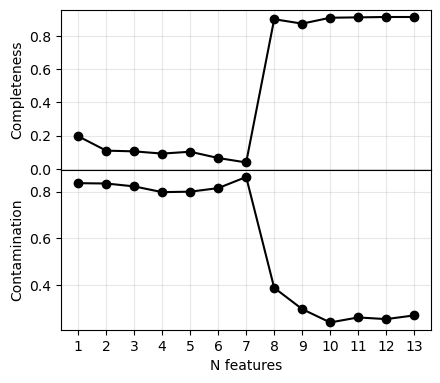

In [48]:
plots(rfc, X_train[:,[7,9]], y_train, completeness_rfc, contamination_rfc)

#### With PCA

In [49]:
completeness_rfc_pca, contamination_rfc_pca, confusion_rfc_pca = compl_cont(rfc, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


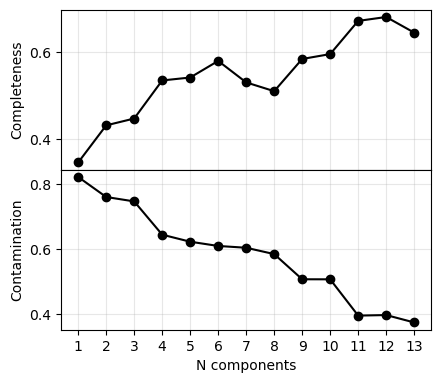

In [50]:
plots(rfc, X_train_pca[:,:2], y_train_pca, completeness_rfc_pca, contamination_rfc_pca, red = True)

In [51]:
#Printing the completeness and contamination for both the cases
print('Without PCA:')
print('Completeness:\n', completeness_rfc)
print('Contamination:\n', contamination_rfc)
print('\nWith PCA:')
print('Completeness:\n', completeness_rfc_pca)
print('Contamination:\n', contamination_rfc_pca)

Without PCA:
Completeness:
 [0.19599109 0.1091314  0.10467706 0.09131403 0.10244989 0.06458797
 0.03786192 0.90200445 0.8752784  0.91091314 0.91314031 0.91536748
 0.91536748]
Contamination:
 [0.83643123 0.83501684 0.82264151 0.79802956 0.8        0.81528662
 0.86290323 0.38821752 0.29695886 0.23977695 0.26126126 0.25408348
 0.26998224]

With PCA:
Completeness:
 [0.34743875 0.43207127 0.44766147 0.53452116 0.54120267 0.57906459
 0.53006682 0.51002227 0.58351893 0.59465479 0.67037862 0.67928731
 0.64365256]
Contamination:
 [0.82272727 0.76108374 0.74748744 0.64497041 0.62325581 0.6101949
 0.60465116 0.58514493 0.5075188  0.50738007 0.39558233 0.3972332
 0.37445887]


In [52]:
#Printing the confusion matrixes in the case of maximum completeness for both the cases
print('Confusion matrix\nWithout PCA:\n', confusion_rfc[np.argmax(completeness_rfc)])
print('\nWith PCA:\n', confusion_rfc_pca[np.argmax(completeness_rfc_pca)])

Confusion matrix
Without PCA:
 [[2411  140]
 [  38  411]]

With PCA:
 [[2350  201]
 [ 144  305]]


In [53]:
depths = np.arange(1,11)
cmp_rfc = []
con_rfc = []
cmp_pca_rfc = []
con_pca_rfc = []
for d in depths:
    rfc = RandomForestClassifier(criterion='entropy', max_depth=d, class_weight='balanced', n_jobs=-1)
    compl_rfc, cont_rfc, conf_rfc = compl_cont(rfc, X_train, X_test, y_train, y_test)
    compl_rfc_pca, cont_rfc_pca, conf_rfc_pca = compl_cont(rfc, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

    cmp_rfc.append(max(compl_rfc))
    con_rfc.append(cont_rfc[np.argmax(compl_rfc)])

    cmp_pca_rfc.append(max(compl_rfc_pca))
    con_pca_rfc.append(cont_rfc_pca[np.argmax(compl_rfc_pca)])

100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


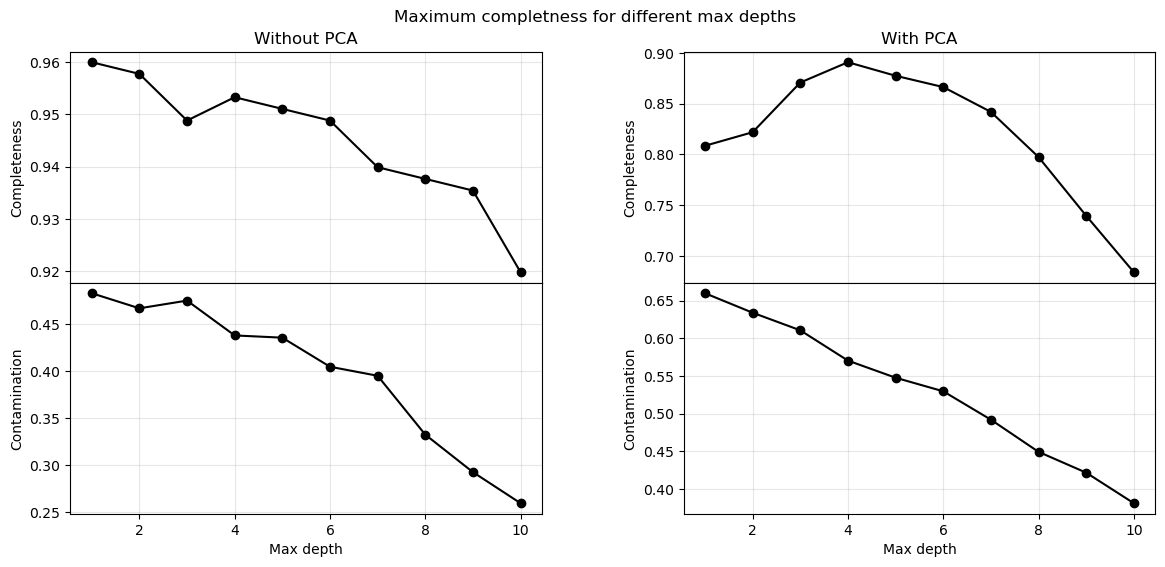

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.3, 'hspace': 0})

axs[0,0].plot(depths, cmp_rfc, color = 'black', marker = 'o')
axs[0,0].set_title('Without PCA')
axs[0,0].set_ylabel('Completeness')
axs[0,0].grid(alpha=0.3)
axs[1,0].plot(depths, con_rfc, color = 'black', marker = 'o')
axs[1,0].set_ylabel('Contamination')
axs[1,0].set_xlabel('Max depth')
axs[1,0].grid(alpha=0.3)

axs[0,1].plot(depths, cmp_pca_rfc, color = 'black', marker = 'o')
axs[0,1].set_title('With PCA')
axs[0,1].set_ylabel('Completeness')
axs[0,1].grid(alpha=0.3)
axs[1,1].plot(depths, con_pca_rfc, color = 'black', marker = 'o')
axs[1,1].set_ylabel('Contamination')
axs[1,1].set_xlabel('Max depth')
axs[1,1].grid(alpha=0.3)

plt.suptitle('Maximum completness for different max depths', y=0.95)
plt.show()

## Gradient boosting

- loss: The loss function to be optimized. For loss ‘exponential’, gradient boosting recovers the AdaBoost algorithm.

#### Without PCA

In [55]:
boost = GradientBoostingClassifier(loss='exponential', max_depth= 6)
completeness_boost, contamination_boost, confusion_boost = compl_cont(boost, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [01:06<00:00,  5.15s/it]


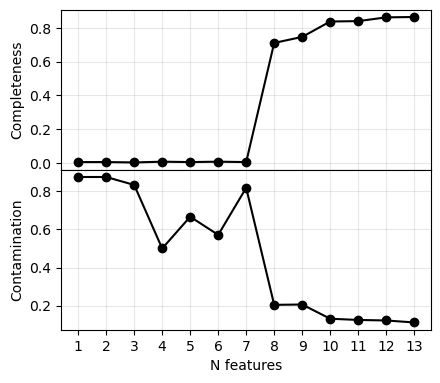

In [56]:
plots(boost, X_train[:,[7,9]], y_train, completeness_boost, contamination_boost)

#### With PCA

In [57]:
completeness_boost_pca, contamination_boost_pca, confusion_boost_pca = compl_cont(boost, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:59<00:00,  4.56s/it]


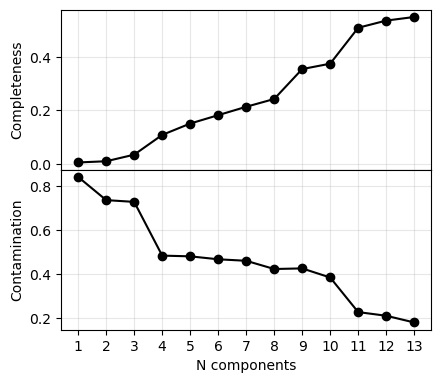

In [58]:
plots(boost, X_train_pca[:,:2], y_train_pca, completeness_boost_pca, contamination_boost_pca, red = True)

In [59]:
#Printing the completeness and contamination for both the cases
print('Without PCA:')
print('Completeness:\n', completeness_boost)
print('Contamination:\n', contamination_boost)
print('\nWith PCA:')
print('Completeness:\n', completeness_boost_pca)
print('Contamination:\n', contamination_boost_pca)

Without PCA:
Completeness:
 [0.00445434 0.00445434 0.00222717 0.00668151 0.00445434 0.00668151
 0.00445434 0.71046771 0.74610245 0.83741648 0.83964365 0.86191537
 0.86414254]
Contamination:
 [0.875      0.875      0.83333333 0.5        0.66666667 0.57142857
 0.81818182 0.20448878 0.20616114 0.13163972 0.12529002 0.12244898
 0.11212815]

With PCA:
Completeness:
 [0.00668151 0.01113586 0.03563474 0.1091314  0.15144766 0.18262806
 0.21380846 0.24276169 0.35412027 0.37416481 0.5077951  0.53452116
 0.54788419]
Contamination:
 [0.84210526 0.73684211 0.72881356 0.48421053 0.48091603 0.46753247
 0.46067416 0.42328042 0.42599278 0.38461538 0.22711864 0.21052632
 0.18      ]


In [60]:
#Printing the confusion matrixes in the case of maximum completeness for both the cases
print('Confusion matrix\nWithout PCA:\n', confusion_boost[np.argmax(completeness_boost)])
print('\nWith PCA:\n', confusion_boost_pca[np.argmax(completeness_boost_pca)])

Confusion matrix
Without PCA:
 [[2502   49]
 [  61  388]]

With PCA:
 [[2497   54]
 [ 203  246]]
